In [ ]:
 
# This code is an example of the highly popular Boosted Trees ML technique
# The aim of this project is to train the model to predict whether a particular passenger profile is likely to have survived the sinking of the Titanic

import numpy as np
import pandas as pd
from IPython.display import clear_output
from matplotlib import pyplot as plt
import tensorflow as tf

# Based on the Google Tutorial: https://www.tensorflow.org/tutorials/estimator/boosted_trees

In [ ]:
# Load dataset (Pandas DataFrame Format)

# The dataset already consists of a training set and an evaluation set:

# Training data: dftrain = training set inputs
#                y_train = training set labels
# Evaluation data: dfeval = evaluation set inputs
#                  y_eval = evaluation set labels

dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')

y_train = dftrain.pop('survived') #Separate the survival status from the test of the model input data (as this is the label)
y_eval = dfeval.pop('survived')

In [ ]:
# We initiate a seed for our random number generator

tf.random.set_seed(123)

In [ ]:
dftrain.head()

# n_siblings_spouses = passenger's siblings or partners aboard
# parch = passenger's parents or children aboard
# fare = the fare the passenger paid 
# deck = deck the passenger was on
# alone = did the passenger embark alone?

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [ ]:
# Summary of dataset statistics
dftrain.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


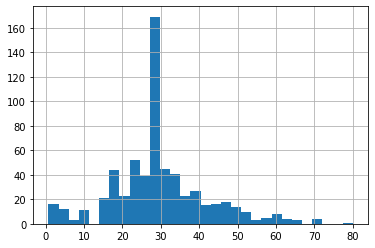

In [ ]:
# The following are examples of how to graph different aspects of the data.

# Graph the age column as a histogram
dftrain.age.hist(bins=30)  # The more bins are chosen, the higher the resolution of the graph
plt.show()

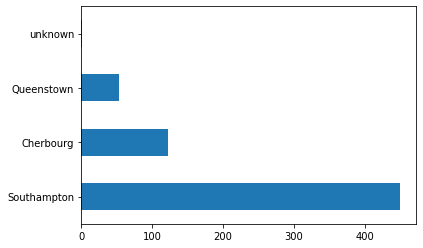

In [ ]:
# Graph the number of people by where they emabarked from
dftrain['embark_town'].value_counts().plot(kind='barh')
plt.show()

In [ ]:
# Number of samples in the training and evaluation sets

dftrain.shape[0], dfeval.shape[0]

(627, 264)

In [ ]:
# We define our function to convert an original feature column to a one-hot encoded column

# tf.feature_column.indicator_column = TensorFlow mutli-hot representation of a categorical column
# tf.feature_column.categorical_column_with_vocabulary_list = TensorFlow categorical column expecting a vocabulary for that column already created in-memory

def one_hot_cat_column(feature_name, vocab):
  return tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_vocabulary_list(feature_name,vocab))

In [ ]:
# These represent all the columns of data available in this Titanic dataset. The dataset contains both categorical and numerical data, which are both relevant to the overall result
# Depending on whether the data is numerical or categorical, it will need to be formatted differently to be fed into the Gradient Boosting Estimator

CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck', 'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

In [ ]:
# We must arrange the categorical data into feature columns to feed to the Gradient Boosting Estimator
# The TensorFlow Gradient Boosting Estimator is able to use both numerical and categorical data (however categorical data must be formatted right)

feature_columns = []

# Need to one-hot encode categorical features in TensorFlow format.
for feature_name in CATEGORICAL_COLUMNS:
  vocabulary = dftrain[feature_name].unique() # For the current column, we create a vocabulary list with all unique feature names
  feature_columns.append(one_hot_cat_column(feature_name, vocabulary)) # We individually convert each column to its one-hot encoded version

# Need to represent the numerical features in TensorFlow format.
for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

# tf.feature_column.numeric_column = TensorFlow representation of numeric features

In [ ]:
# The following is not needed for the code, it is just to visually inspect a single value of the example TensorFlow feature column

# Viewing an example of a one-hot representation feature column:

example = dict(dftrain.head(1))
class_fc = tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_vocabulary_list('class', ('First', 'Second', 'Third')))
print('Feature value: "{}"'.format(example['class'].iloc[0])) 
print('One-hot encoded: ', tf.keras.layers.DenseFeatures([class_fc])(example).numpy())

Feature value: "Third"
One-hot encoded:  [[0. 0. 1.]]


In [ ]:
# The following is not needed for the code, it is just for viewing all of the feature column transformations together for the example single data point (including all its variables)

tf.keras.layers.DenseFeatures(feature_columns)(example).numpy()

array([[22.  ,  1.  ,  0.  ,  1.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ,
         0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ,  0.  ,
         7.25,  1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,
         0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ]], dtype=float32)

In [ ]:
# Creating the input functions:

NUM_EXAMPLES = len(y_train) # Use entire batch since this is such a small dataset.

# Estimators in TensorFlow usually use a similar style for writing input functions: https://www.tensorflow.org/guide/estimator 

def make_input_fn(X, y, n_epochs=None, shuffle=True):

  # We define a function within the larger function to define how to read the dataset
  def input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((dict(X), y)) #by using from_tensor_slices we can read data directly from the pandas dataframe (local memory as opposed to separate file)

    if shuffle:
      dataset = dataset.shuffle(NUM_EXAMPLES)

    # For training, cycle thru dataset as many times as need (equal to n_epochs).
    dataset = dataset.repeat(n_epochs)

    # In memory training doesn't use batching.
    dataset = dataset.batch(NUM_EXAMPLES)
    return dataset

  return input_fn

In [ ]:
# We declare the training input function, data is shuffled by default if option left blank, n_epochs is 0
train_input_fn = make_input_fn(dftrain, y_train) 

# We declare the evaluation input function, data is not shuffled since it does not matter, n_epochs must be declared because the variables are out of order in this declaration (compared to function)
eval_input_fn = make_input_fn(dfeval, y_eval, shuffle=False, n_epochs=1)

In [ ]:
######################################################### Linear Model Training (To establish a benchmark for Boosted Trees training) ################################################
# Trains a linear model to classify instances into one of multiple possible classes

# In this case we do not declare n_classes because the default value is 2, and we want to predict a binary condition (survived or not)
# All items in the input data set should be instances of classes derived from FeatureColumn

linear_est = tf.estimator.LinearClassifier(feature_columns) # Not necessary to initiate n_classes because the default value is two

# Train model.

# max_steps = Number of total steps for which to train model (defaults to infinite) (recommended for non incremental behaviour)
# https://www.tensorflow.org/api_docs/python/tf/estimator/LinearClassifier 

linear_est.train(train_input_fn, max_steps=100) 

# Evaluate the model

# if max_steps or steps variables are not given, the function evaluates the given dataset until it reaches the end of the input values

result = linear_est.evaluate(eval_input_fn)
clear_output()
print(pd.Series(result)) # pd.Series = Declaring the input values as a one-dimensional ndarray with axis labels equal to the terms of the input values

accuracy                  0.765152
accuracy_baseline         0.625000
auc                       0.832844
auc_precision_recall      0.789631
average_loss              0.478908
label/mean                0.375000
loss                      0.478908
precision                 0.703297
prediction/mean           0.350790
recall                    0.646465
global_step             100.000000
dtype: float64


In [ ]:
############################################################ Boosted Trees Training ####################################################################

n_batches = 1 # Since data fits into memory, use entire dataset per layer. It will be faster

# The total number of batches is total number of data divided by batch size. In this case we do not declare n_classes because the default value is 2, and we want to predict a binary condition (survived or not)

est = tf.estimator.BoostedTreesClassifier(feature_columns, n_batches_per_layer=n_batches) # n_batches_per_layer = The number of batches to collect statistics per layer

# The model will stop training once the specified number of trees is built (default number is 100 but changing it does not seem to matter), not based on the number of steps.
# https://www.tensorflow.org/api_docs/python/tf/estimator/BoostedTreesClassifier 

est.train(train_input_fn, max_steps=100)

# Eval.
result = est.evaluate(eval_input_fn)
clear_output()
print(pd.Series(result))

accuracy                  0.833333
accuracy_baseline         0.625000
auc                       0.874197
auc_precision_recall      0.858434
average_loss              0.406781
label/mean                0.375000
loss                      0.406781
precision                 0.795699
prediction/mean           0.383399
recall                    0.747475
global_step             100.000000
dtype: float64


In [ ]:
predictions = list(est.predict(eval_input_fn)) # Yields predictions for given features.

print(predictions)

# For every sample, the predict function estimates the probability of each group (first probability corresponds to not surviving, second to survivors) 

prediction_probabilities = pd.Series([pred['probabilities'][1] for pred in predictions]) # This will tell us the possibility that each passenger is expected to not survive

num_of_predictions = len(prediction_probabilities)

# In this case I arbitrarily decided that those with less than 50% probability of survival are labelled as "not a survivor"

for i in range(num_of_predictions):
    if prediction_probabilities[i] >= 0.5:
        predicted_status =  "survivor"
    else:
        predicted_status =  "not a survivor"
        
    print(int(i+1), " ", predicted_status)

#print(prediction_probabilities)


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpxn466b3q/model.ckpt-100
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
[{'logits': array([-2.1454346], dtype=float32), 'logistic': array([0.10475862], dtype=float32), 'probabilities': array([0.8952414 , 0.10475861], dtype=float32), 'class_ids': array([0]), 'classes': array([b'0'], dtype=object), 'all_class_ids': array([0, 1], dtype=int32), 'all_classes': array([b'0', b'1'], dtype=object)}, {'logits': array([-0.8396695], dtype=float32), 'logistic': array([0.3016044], dtype=float32), 'probabilities': array([0.6983956, 0.3016044], dtype=float32), 'class_ids': array([0]), 'classes': array([b'0'], dtype=object), 'all_class_ids': array([0, 1], dtype=int32), 'all_classes': array([b'0', b'1'], dtype=object)}, {'logits': array([-0.5132254], dtype=float32), 'logistic': array([0.37443772], dtype=float32)